###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c) 2019 Daniel Koehn, based on (c)2018 L.A. Barba, G.F. Forsyth [CFD Python](https://github.com/barbagroup/CFDPython#cfd-python), (c)2014 L.A. Barba, I. Hawke, B. Knaepen [Practical Numerical Methods with Python](https://github.com/numerical-mooc/numerical-mooc#practical-numerical-methods-with-python), also under CC-BY.

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# Performance optimization of the 2D heat equation finite difference modelling code

During the [last class](http://nbviewer.ipython.org/urls/github.com/daniel-koehn/Differential-equations-earth-system/tree/master/06_Heat_2D/01_Heat_Equation_2D.ipynb), we developed a 2D heat equation FD code based on the 1D code. However, if we investigate this "vanilla" Python implementation for a computationally more demanding test problem,  the runtime performance is quite underwhelming. Therefore, the aim of this lesson is to optimize the performance of the 2D heat equation code. 

Let's start by setting up our Python compute environment and reuse the `ftcs` code from the last class.

In [2]:
# Import libraries
import numpy
from matplotlib import pyplot
%matplotlib inline

In [3]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
def ftcs_vanilla(T0, nt, dt, dx, dy, alpha):
    """
    Computes and returns the temperature distribution
    after a given number of time steps.
    Explicit integration using forward differencing
    in time and central differencing in space, with
    Neumann conditions (zero-gradient) on top and right
    boundaries and Dirichlet conditions on bottom and
    left boundaries.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 2D array of floats.
    nt : integer
        Maximum number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Grid spacing in the x direction.
    dy : float
        Grid spacing in the y direction.
    alpha : float
        Thermal diffusivity.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 2D array of floats.
    """
    # Define some constants.
    sigma_x = alpha * dt / dx**2
    sigma_y = alpha * dt / dy**2
    
    # Integrate in time.
    T = T0.copy()
    
    # Estimate number of grid points in x- and y-direction
    ny, nx = T.shape
    
    # Indices of the model center
    I, J = int(nx / 2), int(ny / 2)  
    
    # Time loop
    for n in range(nt):
        
        # store old temperature field
        Tn = T.copy()
        
        # loop over spatial grid 
        for i in range(1,nx-1):
            for j in range(1,ny-1):
                
                T[j, i] = (Tn[j, i] +
                         sigma_x * (Tn[j, i+1] - 2.0 * Tn[j, i] + Tn[j, i-1]) +
                         sigma_y * (Tn[j+1, i] - 2.0 * Tn[j, i] + Tn[j-1, i]))
                
        # Apply Neumann conditions (zero-gradient).
        T[-1, :] = T[-2, :]
        T[:, -1] = T[:, -2]
        
    return T

When defining the modelling parameters, we increase the number of gridpoint in x- and y-direction from `nx=ny=21`, used in the last class to `nx=ny=251` to get a better idea of the required runtime to solve a medium sized problem:

In [5]:
# Definition of modelling parameters
# ----------------------------------
Lx = 0.01  # length of the plate in the x direction
Ly = 0.01  # height of the plate in the y direction
nx = 251   # number of points in the x direction
ny = 251   # number of points in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction
dy = Ly / (ny - 1)  # grid spacing in the y direction
alpha = 1e-4  # thermal diffusivity of the plate

# Define the locations along a gridline.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(0.0, Ly, num=ny)

# Compute the initial temperature distribution.
Tb = 100.0  # temperature at the left and bottom boundaries
T0 = 20.0 * numpy.ones((ny, nx))
T0[0, :] = Tb
T0[:, 0] = Tb

We don't want our solution blowing up, so let's find a time step with $\frac{\alpha \Delta t}{\Delta x^2} = \frac{\alpha \Delta t}{\Delta y^2} = \frac{1}{4}$. 

In [6]:
# Set the time-step size based on CFL limit.
sigma = 0.25
dt = sigma * min(dx, dy)**2 / alpha  # time-step size
nt = 500  # number of time steps to compute

Let 's estimate the runtime of the `ftcs_vanilla` Python code by using the magic function `%%time`

In [7]:
%%time

# Compute the temperature distribution on the CPU.
T = ftcs_vanilla(T0, nt, dt, dx, dy, alpha)

Wall time: 45.2 s


You should adapt the value of the timing measurement `t_vanilla_python` below  by the runtime value of your computer.

In [8]:
t_vanilla_python = 45.2

## Just-In-Time (JIT) code compilation with Numba 

The poor performance of the vanilla Python code is due to the nested FOR loops to compute the 2nd spatial FD derivatives. We can optimize the performance using the `Numba ` library  for Python ([http://numba.pydata.org/](http://numba.pydata.org/)) which turns Python functions into C-style compiled functions using [LLVM](https://en.wikipedia.org/wiki/LLVM). A nice introduction to Numba was presented at the SciPy conference 2016 by Gil Forsyth & Lorena Barba in a workshop with the title 

**Numba: Tell those C++ bullies to get lost**

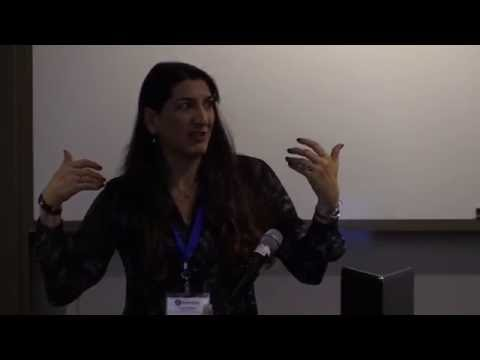

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('SzBi3xdEF2Y')

The associated Jupyter notebooks can be cloned from [here](https://github.com/barbagroup/numba_tutorial_scipy2016).

First, we have to install Numba, which is quite easy using Anaconda:

`conda install numba` 

From the Numba library we import **jit**: 

In [10]:
# import JIT from Numba
from numba import jit

The only thing, we modify in our original Python code is to add the function decorator 

`@jit(nopython=True)`

which tags the function `FD_2D_acoustic_JIT` to be compiled:

In [11]:
# FTCS code to solve the 2D heat equation with JIT optimization
# -------------------------------------------------------------
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def ftcs_JIT(T0, nt, dt, dx, dy, alpha):
    """
    Computes and returns the temperature distribution
    after a given number of time steps.
    Explicit integration using forward differencing
    in time and central differencing in space, with
    Neumann conditions (zero-gradient) on top and right
    boundaries and Dirichlet conditions on bottom and
    left boundaries.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 2D array of floats.
    nt : integer
        Maximum number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Grid spacing in the x direction.
    dy : float
        Grid spacing in the y direction.
    alpha : float
        Thermal diffusivity.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 2D array of floats.
    """
    # Define some constants.
    sigma_x = alpha * dt / dx**2
    sigma_y = alpha * dt / dy**2
    
    # Integrate in time.
    T = T0.copy()
    
    # Estimate number of grid points in x- and y-direction
    ny, nx = T.shape
    
    # Indices of the model center
    I, J = int(nx / 2), int(ny / 2)  
    
    # Time loop
    for n in range(nt):
        
        # store old temperature field
        Tn = T.copy()
        
        # loop over spatial grid 
        for i in range(1,nx-1):
            for j in range(1,ny-1):
                
                T[j, i] = (Tn[j, i] +
                         sigma_x * (Tn[j, i+1] - 2.0 * Tn[j, i] + Tn[j, i-1]) +
                         sigma_y * (Tn[j+1, i] - 2.0 * Tn[j, i] + Tn[j-1, i]))
                
        # Apply Neumann conditions (zero-gradient).
        T[-1, :] = T[-2, :]
        T[:, -1] = T[:, -2]
        
    return T

Let's run the code `ftcs_JIT` 

In [13]:
%%time
T_JIT = ftcs_JIT(T0, nt, dt, dx, dy, alpha)

Wall time: 78.1 ms


Wow, you don't have to wait 45 s, but only 626 ms. Run the cell above again ...

... and you see that the runtime is suddenly further decreased to 78.1 ms. This performance improvement can be explained by the code compilation during the first run of the code. So by simply using the `@jit` function decorator we get a performance increase of **579x** compared to the non-optimized Python code - not too bad.

In [14]:
t_JIT_python = 0.0781  # runtime of JIT compiled Python code (s)

Another approach to get rid of the nested FOR-loops is to use Numpy array operations:

In [15]:
# FTCS code to solve the 2D heat equation with Numpy array operations
# -------------------------------------------------------------------
def ftcs_numpy(T0, nt, dt, dx, dy, alpha):
    """
    Computes and returns the temperature distribution
    after a given number of time steps.
    Explicit integration using forward differencing
    in time and central differencing in space, with
    Neumann conditions (zero-gradient) on top and right
    boundaries and Dirichlet conditions on bottom and
    left boundaries.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 2D array of floats.
    nt : integer
        Maximum number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Grid spacing in the x direction.
    dy : float
        Grid spacing in the y direction.
    alpha : float
        Thermal diffusivity.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 2D array of floats.
    """
    # Define some constants.
    sigma_x = alpha * dt / dx**2
    sigma_y = alpha * dt / dy**2
    
    # Integrate in time.
    T = T0.copy()
    
    # Estimate number of grid points in x- and y-direction
    ny, nx = T.shape
    
    # Indices of the model center
    I, J = int(nx / 2), int(ny / 2)  
    
    # Time loop
    for n in range(nt):
        
        # Old FD approximation of spatial derivative by 3-point operator
        # using nested FOR-loops is replaced by ...
        
        # store old temperature field
        #Tn = T.copy()
        
        # loop over spatial grid 
        #for i in range(1,nx-1):
        #    for j in range(1,ny-1):
        #        
        #       T[j, i] = (Tn[j, i] +
        #                 sigma_x * (Tn[j, i+1] - 2.0 * Tn[j, i] + Tn[j, i-1]) +
        #                 sigma_y * (Tn[j+1, i] - 2.0 * Tn[j, i] + Tn[j-1, i]))
        
        # ... Numpy array operations:
        T[1:-1, 1:-1] = (T[1:-1, 1:-1] +
                         sigma_x * (T[1:-1, 2:] - 2.0 * T[1:-1, 1:-1] + T[1:-1, :-2]) +
                         sigma_y * (T[2:, 1:-1] - 2.0 * T[1:-1, 1:-1] + T[:-2, 1:-1]))
        
            
        # Apply Neumann conditions (zero-gradient).
        T[-1, :] = T[-2, :]
        T[:, -1] = T[:, -2]
        
    return T

In [16]:
%%time
T_numpy = ftcs_numpy(T0, nt, dt, dx, dy, alpha)

Wall time: 469 ms


In [17]:
t_numpy_python = 0.469  # runtime of JIT compiled Python code (s)

The runtime 469 ms of the `NumPy` version is not as fast as the 78 ms of the JIT version, but a **96x** improvement is still better than the non-optimized version. Can JIT also improve the performance of `ftcs_numpy`?

In [18]:
# FTCS code to solve the 2D heat equation with Numpy array operations + JIT optimization
# --------------------------------------------------------------------------------------
@jit(nopython=True) # use Just-In-Time (JIT) Compilation for C-performance
def ftcs_numpy_jit(T0, nt, dt, dx, dy, alpha):
    """
    Computes and returns the temperature distribution
    after a given number of time steps.
    Explicit integration using forward differencing
    in time and central differencing in space, with
    Neumann conditions (zero-gradient) on top and right
    boundaries and Dirichlet conditions on bottom and
    left boundaries.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 2D array of floats.
    nt : integer
        Maximum number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Grid spacing in the x direction.
    dy : float
        Grid spacing in the y direction.
    alpha : float
        Thermal diffusivity.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 2D array of floats.
    """
    # Define some constants.
    sigma_x = alpha * dt / dx**2
    sigma_y = alpha * dt / dy**2
    
    # Integrate in time.
    T = T0.copy()
    
    # Estimate number of grid points in x- and y-direction
    ny, nx = T.shape
    
    # Indices of the model center
    I, J = int(nx / 2), int(ny / 2)  
    
    # Time loop
    for n in range(nt):
        
        # Old FD approximation of spatial derivative by 3-point operator
        # using nested FOR-loops is replaced by ...
        
        # store old temperature field
        #Tn = T.copy()
        
        # loop over spatial grid 
        #for i in range(1,nx-1):
        #    for j in range(1,ny-1):
        #        
        #       T[j, i] = (Tn[j, i] +
        #                 sigma_x * (Tn[j, i+1] - 2.0 * Tn[j, i] + Tn[j, i-1]) +
        #                 sigma_y * (Tn[j+1, i] - 2.0 * Tn[j, i] + Tn[j-1, i]))
        
        # ... Numpy array operations:
        T[1:-1, 1:-1] = (T[1:-1, 1:-1] +
                         sigma_x * (T[1:-1, 2:] - 2.0 * T[1:-1, 1:-1] + T[1:-1, :-2]) +
                         sigma_y * (T[2:, 1:-1] - 2.0 * T[1:-1, 1:-1] + T[:-2, 1:-1]))
        
            
        # Apply Neumann conditions (zero-gradient).
        T[-1, :] = T[-2, :]
        T[:, -1] = T[:, -2]
        
    return T

In [20]:
%%time
T_numpy_JIT = ftcs_numpy_jit(T0, nt, dt, dx, dy, alpha)

Wall time: 125 ms


In [21]:
t_numpy_python_JIT = 0.125  # runtime of JIT compiled Python code (s)

So JIT could also improve the performance of the code using `NumPy` array operations, but the performance of the compiled code with the nested FOR loops still shows a slight edge in terms of runtime. To check if the optimized codes are not only fast but still produce reasonable modelling results, it is a good idea to check if the temperature profiles computed with the optimized codes coincide. 

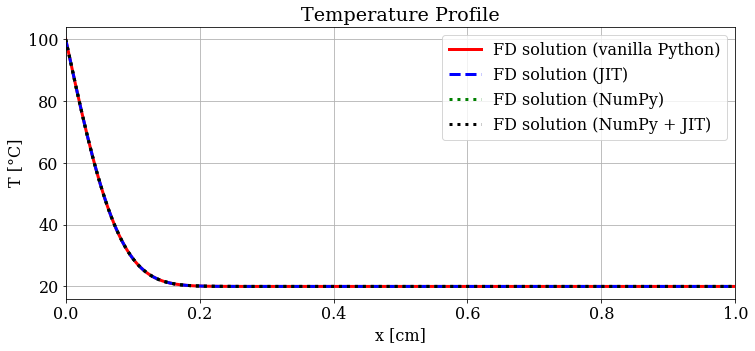

In [23]:
# Compare temperature profiles 
# ----------------------------------------------
# Define figure size
pyplot.rcParams['figure.figsize'] = 12, 5
pyplot.plot(x*100, T[(int)(ny/2),:], 'r-',lw=3,label="FD solution (vanilla Python)")
pyplot.plot(x*100, T_JIT[(int)(ny/2),:], 'b--',lw=3,label="FD solution (JIT)")
pyplot.plot(x*100, T_numpy[(int)(ny/2),:], 'g:',lw=3,label="FD solution (NumPy)")
pyplot.plot(x*100, T_numpy_JIT[(int)(ny/2),:], 'k:',lw=3,label="FD solution (NumPy + JIT)")
pyplot.xlim(x[0]*100, x[-1]*100)
pyplot.title('Temperature Profile')
pyplot.xlabel('x [cm]')
pyplot.ylabel('T [°C]')
pyplot.legend()
pyplot.grid()
pyplot.show() 

Finally, we produce some nice bar charts to compare the performance of the different codes developed in this `Jupyter` notebook:

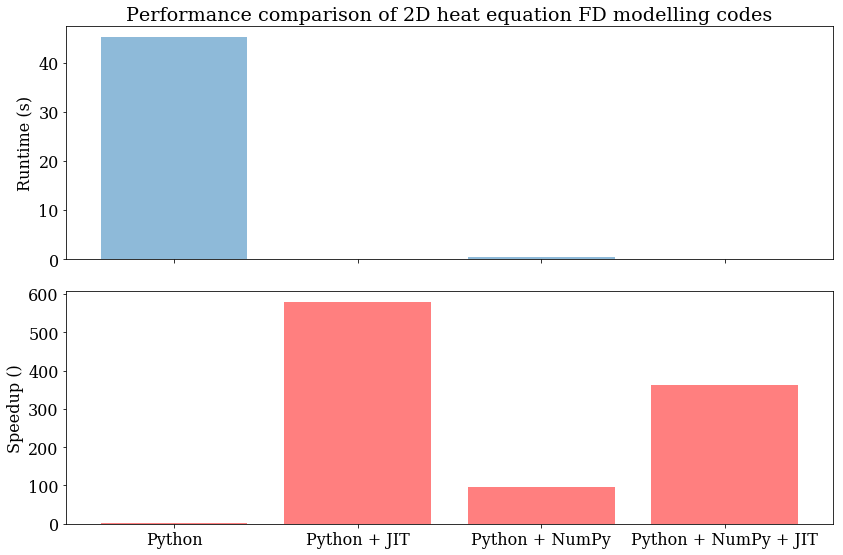

In [24]:
# define codes
codes = ('Python', 'Python + JIT', 'Python + NumPy', 'Python + NumPy + JIT')
y_pos = numpy.arange(len(codes))

# runtime
performance = [t_vanilla_python,t_JIT_python,t_numpy_python,t_numpy_python_JIT]

# speed-up with respect to the non-optimized code
speedup = [t_vanilla_python/t_vanilla_python,
           t_vanilla_python/t_JIT_python,
           t_vanilla_python/t_numpy_python,
           t_vanilla_python/t_numpy_python_JIT]

# Define figure size
pyplot.rcParams['figure.figsize'] = 12, 8

# Plot runtimes of 2D heat equation FD codes
ax1 = pyplot.subplot(211)

pyplot.bar(y_pos, performance, align='center', alpha=0.5)
pyplot.xticks(y_pos, codes)
pyplot.ylabel('Runtime (s)')
pyplot.title('Performance comparison of 2D heat equation FD modelling codes')
 
# make tick labels invisible
pyplot.setp(ax1.get_xticklabels(), visible=False)   

# Plot speedup of 2D heat equation FD codes
ax2 = pyplot.subplot(212, sharex=ax1)    

pyplot.bar(y_pos, speedup, align='center', alpha=0.5,color='r')
pyplot.xticks(y_pos, codes)
pyplot.ylabel('Speedup ()')
pyplot.tight_layout() 
pyplot.show()

Is this the best result we can achieve or are further code improvements possible? 

Using domain decomposition with the **Message-Passing Interface MPI** to distribute the workload over multiple CPU cores, combined with a partioning of the tasks in each domain using **Multithreading** can significantly improve the code performance. One key is the manual optimization of CPU and GPU kernels, especially regarding memory access times or communication between MPI processes.

More details about MPI and Multithreading optimizations are beyond the scope of this course, but will be the topic of a future HPC lecture ...

To get an idea about the difference between JIT optimized Python codes and manually optimized codes, I recommend a SciPy 2016 talk by Andreas Klöckner:

**High Performance with Python: Architectures, Approaches & Applications**

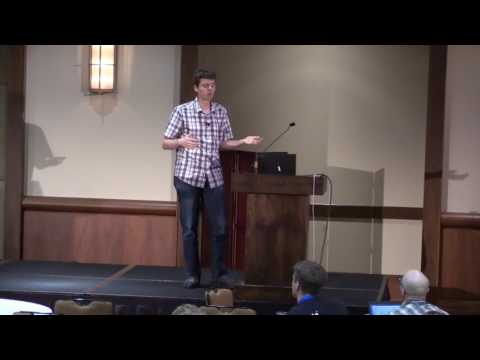

In [25]:
from IPython.display import YouTubeVideo
YouTubeVideo('Zz_6P5qAJck')

## What we learned:

* The performance of our 2D heat equation modelling code, developed in the previous class, suffered from the nested FOR loops over the spatial finite difference grid
* Using JIT compilation of the Python code using `Numba`, the performance could be significantly improved by a factor 579x
* Alternatively, we can replace the nested FOR loops by `NumPy` array operations and combine with JIT optimization to improve the runtime performance
* When optimizing the performance of a code, always check if the modelling results of your optimized Python codes are still correct